# Import

In [398]:
import matplotlib.pyplot as plt
import missingno as mno
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('white')

In [167]:
orders = pd.read_csv("csv/orders.csv").drop(
    ["index", "order_approved_at", "order_delivered_carrier_date"], axis=1
)
payments = pd.read_csv("csv/payments.csv").drop(
    ["index", "payment_installments", "payment_sequential", "payment_type"], axis=1
)
reviews = pd.read_csv("csv/reviews.csv").drop(
    ["index", "review_id", "review_answer_timestamp"], axis=1
)
customers = pd.read_csv("csv/customers.csv").drop(
    ["index", "customer_state", "customer_zip_code_prefix", "customer_city"], axis=1
)

# Outer join

In [168]:
df = (
    orders.merge(payments, how="outer", on="order_id")
    .merge(reviews, how="outer", on="order_id")
    .merge(customers, how="outer", on="customer_id")
).drop("customer_id", axis=1)

df.head()

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,review_comment_title,review_comment_message,review_creation_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,18.12,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,2.00,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,7c396fd4830fd04220f754e42b4e5bff
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,18.59,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,7c396fd4830fd04220f754e42b4e5bff
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,af07308b275d755c9edb36a90c618231
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,5.0,NaN,NaN,2018-08-18 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8


# Conversion datetime

In [169]:
for dt in [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_creation_date",
]:
    df[dt] = pd.to_datetime(df[dt])

# EDA

<Axes: >

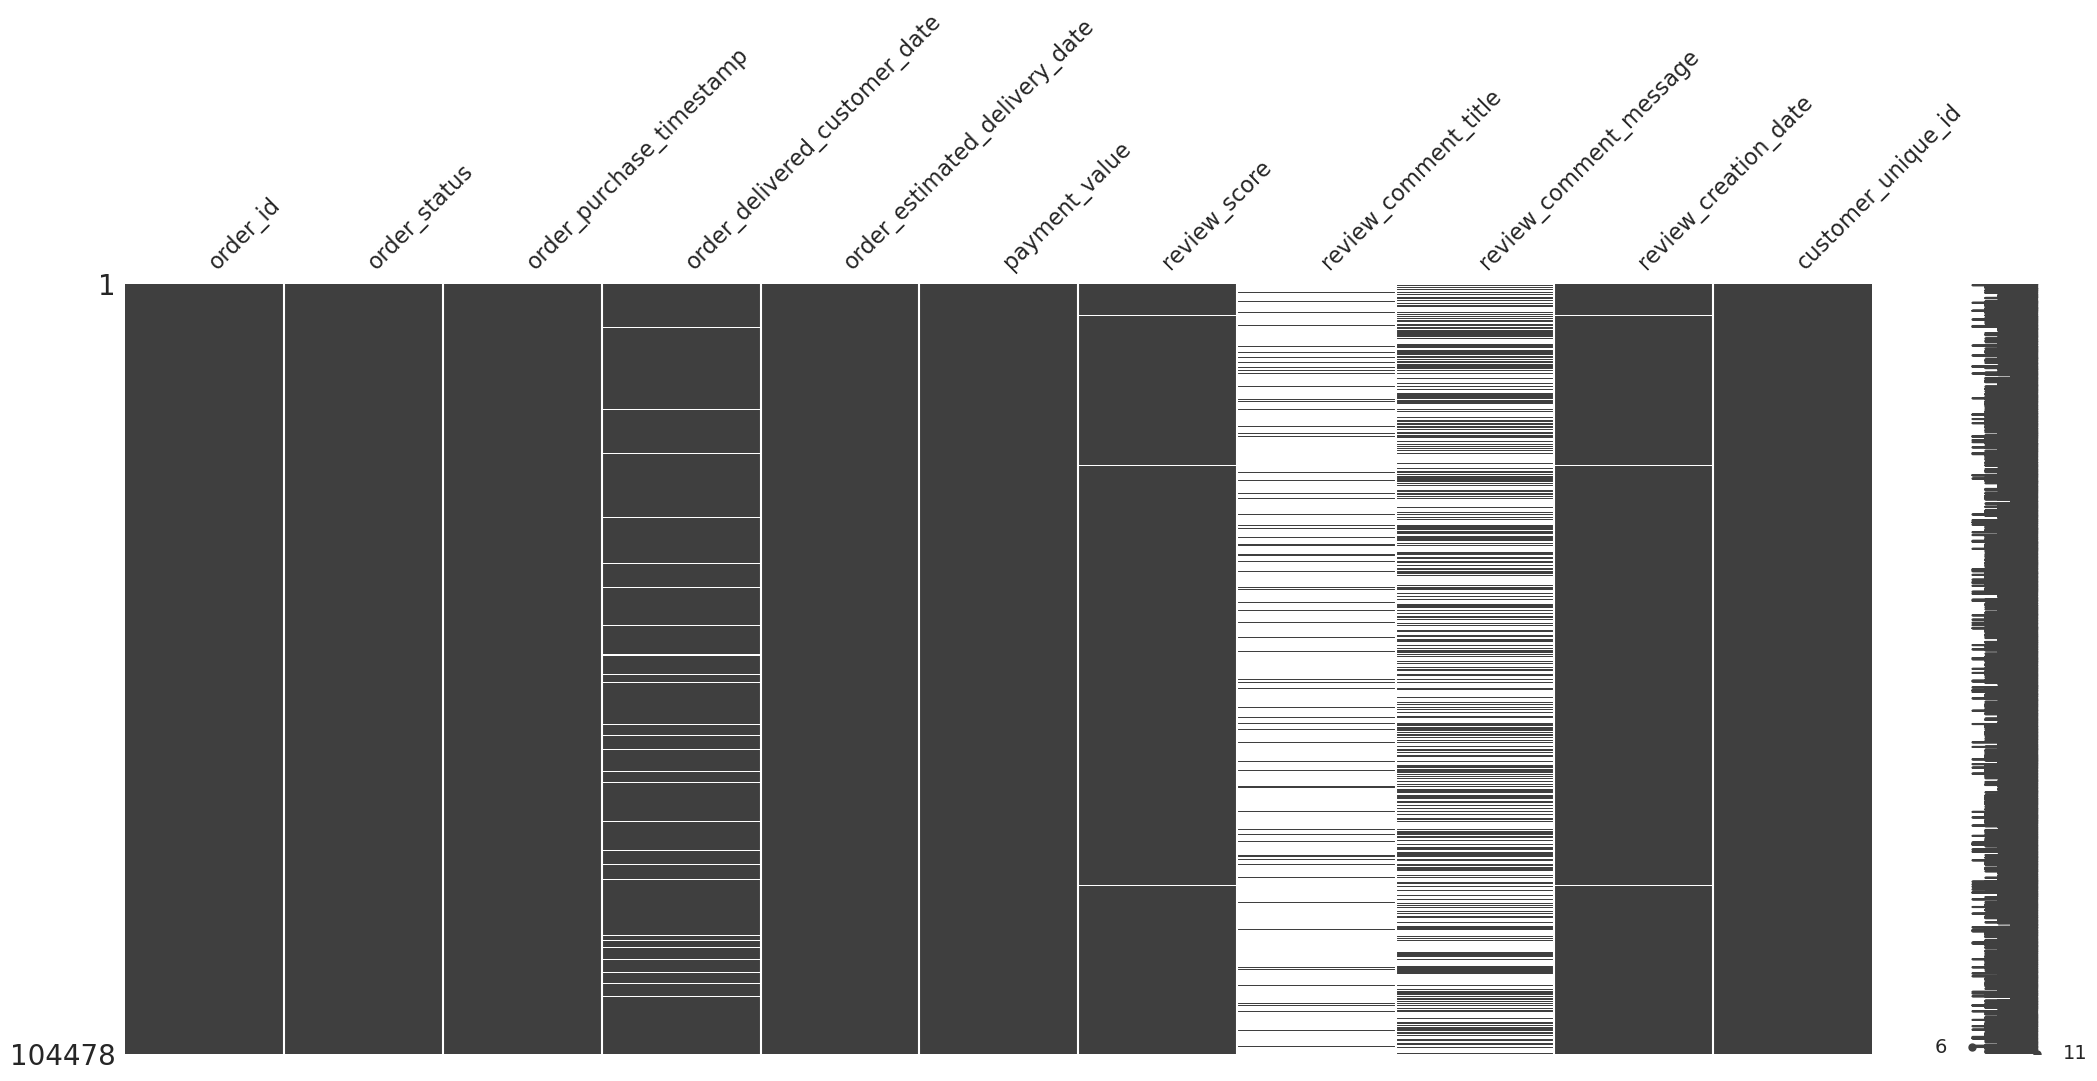

In [170]:
mno.matrix(df)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104478 entries, 0 to 104477
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       104478 non-null  object        
 1   order_status                   104478 non-null  object        
 2   order_purchase_timestamp       104478 non-null  datetime64[ns]
 3   order_delivered_customer_date  101324 non-null  datetime64[ns]
 4   order_estimated_delivery_date  104478 non-null  datetime64[ns]
 5   payment_value                  104477 non-null  float64       
 6   review_score                   103678 non-null  float64       
 7   review_comment_title           11996 non-null   object        
 8   review_comment_message         42816 non-null   object        
 9   review_creation_date           103678 non-null  datetime64[ns]
 10  customer_unique_id             104478 non-null  object        
dtype

### Orders analysis

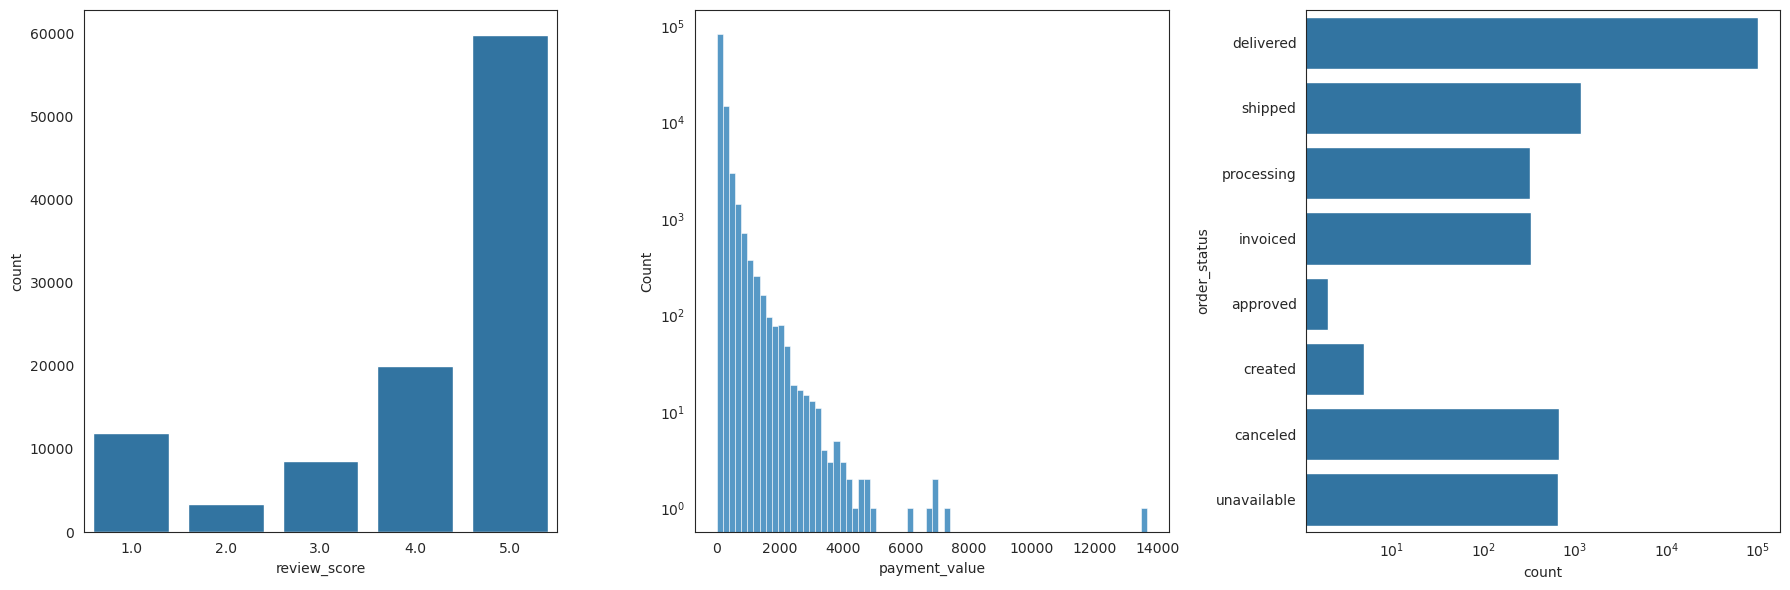

In [172]:
fig = plt.figure(figsize=(18, 6))

fig.add_subplot(131)
sns.countplot(data=df, x="review_score")

fig.add_subplot(132)
sns.histplot(data=df, x="payment_value", bins=70)
plt.yscale("log")

fig.add_subplot(133)
sns.countplot(
    data=df,
    y="order_status",
    order=[
        "delivered",
        "shipped",
        "processing",
        "invoiced",
        "approved",
        "created",
        "canceled",
        "unavailable",
    ],
)
plt.xscale("log")

plt.tight_layout()

# Feature Engineering

## Missing payment imputation

In [173]:
df.loc[df["payment_value"].isna(), "payment_value"] = 0

## Missing review imputation

In [174]:
df.loc[df["review_comment_message"].isna(), "review_comment_message"] = ""
df.loc[df["review_comment_title"].isna(), "review_comment_title"] = ""

## Addtitional features

### Delay

In [212]:
NOW = df["order_purchase_timestamp"].value_counts().sort_index(ascending=False).index[0]

In [243]:
df["delay"] = df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]

### Delivered

In [ ]:
df["delivered"] = df["order_status"] == "delivered"

### Time since order

In [244]:
df["time_since_order"] = NOW - df["order_purchase_timestamp"]

### Canceled or unavailable

In [245]:
df["canceled_or_unavailable"] = df["order_status"].map(
    lambda status: status in ["canceled", "unavailable"]
)

### Delay imputation

In [246]:
df["delay"] = df["delay"].fillna(
    df["canceled_or_unavailable"]
    .map({True: pd.Timedelta(0), False: None})
    .combine_first(df["time_since_order"])
)

In [250]:
df

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,review_comment_title,review_comment_message,review_creation_date,customer_unique_id,delay,time_since_order,canceled_or_unavailable,delivered
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,18.12,4.0,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45,False,True
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,2.00,4.0,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45,False,True
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,18.59,4.0,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45,False,True
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,141.46,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,af07308b275d755c9edb36a90c618231,-6 days +15:27:45,84 days 20:48:41,False,True
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,179.12,5.0,,,2018-08-18,3a653a41f6f9fc3d2a113cf8398680e8,-18 days +18:06:29,70 days 08:51:29,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28,85.08,5.0,,,2017-03-22,6359f309b166b0196dbf7ad2ac62bb5a,-11 days +15:08:01,587 days 07:36:13,False,True
104474,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-28 17:37:56,2018-03-02,195.00,4.0,,So uma peça que veio rachado mas tudo bem rs,2018-03-01,da62f9e57a76d978d02ab5362c509660,-2 days +17:37:56,253 days 04:31:20,False,True
104475,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-09-21 11:24:17,2017-09-27,271.01,5.0,,Foi entregue antes do prazo.,2017-09-22,737520a9aad80b3fbbdad19b66b37b30,-6 days +11:24:17,416 days 02:43:35,False,True
104476,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,441.16,2.0,,Foi entregue somente 1. Quero saber do outro p...,2018-01-26,5097a5312c8b157bb7be58ae360ef43c,-21 days +23:32:54,281 days 20:01:51,False,True


## Group by "order_id"

In [369]:
df_agg_order = (
    df.groupby("order_id")
    .agg(
        {
            "customer_unique_id": "first",
            "payment_value": "sum",
            "review_score": "mean",
            "review_comment_title": "max",
            "review_comment_message": "max",
            "time_since_order": "first",
            "delay": "max",
            "delivered": "first",
            "canceled_or_unavailable": "first",
        }
    )
    .reset_index()
)

In [370]:
df_agg_order["time_delta_since_last_order"] = -df_agg_order.groupby(
    "customer_unique_id"
)["time_since_order"].transform(lambda x: x.sort_values(ascending=False).diff())

df_agg_order["time_delta_since_last_order"] = df_agg_order[
    "time_delta_since_last_order"
].combine_first(df_agg_order["time_since_order"])

In [372]:
df_agg_order

,order_id,customer_unique_id,payment_value,review_score,review_comment_title,review_comment_message,time_since_order,delay,delivered,canceled_or_unavailable,time_delta_since_last_order
0,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,89.71,1.0,Troca,"Por gentileza, trocar meu produto pois comprei...",0 days 00:00:00,0 days 00:00:00,False,True,0 days 00:00:00
1,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,222.03,5.0,Gostei,Os produtos são de boa qualidade e o preço que...,0 days 21:14:16,0 days 00:00:00,False,True,127 days 03:24:15
2,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,197.55,1.0,,quero devolver o produto comprei um veio outro...,13 days 22:34:49,0 days 00:00:00,False,True,30 days 00:09:55
3,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,80.38,2.0,,,16 days 02:00:09,0 days 00:00:00,False,True,46 days 02:20:26
4,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,137.03,1.0,,o produto foi entregue errado eu estou esperad...,18 days 08:17:15,0 days 00:00:00,False,True,18 days 08:17:15
...,...,...,...,...,...,...,...,...,...,...,...
99436,71303d7e93b399f5bcd537d124c0bcfa,0eb1ee9dba87f5b36b4613a65074337c,109.34,1.0,,,744 days 19:22:26,0 days 00:00:00,False,True,744 days 19:22:26
99437,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,0.00,1.0,,nao recebi o produto e nem resposta da empresa,762 days 05:13:40,36 days 07:47:38,True,False,762 days 05:13:40
99438,809a282bbd5dbcabb6f2f724fca862ec,009b0127b727ab0ba422f6d9604487c7,40.95,1.0,,MEU PEDIDO NÃO FOI ENTREGUE E NÃO FOI DADA NEN...,764 days 02:05:59,0 days 00:00:00,False,True,764 days 02:05:59
99439,e5fa5a7210941f7d56d0208e4e071d35,4854e9b3feff728c13ee5fc7d1547e92,75.06,1.0,,Comprei dois produtos desta loja parceira da l...,772 days 17:14:44,0 days 00:00:00,False,True,772 days 17:14:44


## Group by "customer_id"

In [373]:
review_count = lambda reviews: sum([bool(r) for r in reviews])
frac_bool = lambda col: round(sum([val for val in col]) / len(col), 2)

df_agg_customer = df_agg_order.groupby("customer_unique_id").agg(
    {
        "payment_value": "sum",
        "review_score": "mean",
        "review_comment_title": review_count,
        "review_comment_message": review_count,
        "time_since_order": "min",
        "time_delta_since_last_order": "mean",
        "delay": "mean",
        "delivered": frac_bool,
        "canceled_or_unavailable": frac_bool
    }
)

In [374]:
df_agg_customer.columns = [
    "total_payments",
    "mean_review_score",
    "n_review_title",
    "n_review_msg",
    "time_since_order",
    "mean_time_delta_between_orders",
    "mean_delay",
    "frac_delivered",
    "frac_canceled_or_unavailable",
]

In [375]:
df_agg_customer

,total_payments,mean_review_score,n_review_title,n_review_msg,time_since_order,mean_time_delta_between_orders,mean_delay,frac_delivered,frac_canceled_or_unavailable
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,141.90,5.0,1,1,160 days 06:33:51,160 days 06:33:51,-5 days +20:48:37,1.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,4.0,0,0,163 days 06:18:51,163 days 06:18:51,-5 days +18:02:42,1.0,0.0
0000f46a3911fa3c0805444483337064,86.22,3.0,0,0,585 days 20:25:15,585 days 20:25:15,-2 days +14:38:47,1.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,43.62,4.0,0,1,369 days 21:00:37,369 days 21:00:37,-12 days +21:23:05,1.0,0.0
0004aac84e0df4da2b147fca70cf8255,196.89,5.0,0,0,336 days 21:44:36,336 days 21:44:36,-8 days +23:08:56,1.0,0.0
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,5.0,0,0,495 days 20:29:42,495 days 20:29:42,-27 days +09:22:00,1.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,84.58,4.0,0,0,310 days 21:22:22,310 days 21:22:22,-3 days +22:28:20,1.0,0.0
ffff371b4d645b6ecea244b27531430a,112.46,5.0,0,0,617 days 01:41:02,617 days 01:41:02,-30 days +12:45:04,1.0,0.0


## Imputation and normalization

In [405]:
df_norm = df_agg_customer.copy()

In [406]:
si = SimpleImputer(strategy='mean')
df_norm["mean_review_score"] = si.fit_transform(np.array(df_norm["mean_review_score"]).reshape(-1, 1))

In [407]:
for col in ["time_since_order", "mean_time_delta_between_orders", "mean_delay"]:
    df_norm[col] = df_norm[col].apply(lambda x: x.total_seconds())

In [408]:
df_norm

,total_payments,mean_review_score,n_review_title,n_review_msg,time_since_order,mean_time_delta_between_orders,mean_delay,frac_delivered,frac_canceled_or_unavailable
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,141.90,5.0,1,1,13847631.0,13847631.0,-357083.0,1.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,4.0,0,0,14105931.0,14105931.0,-367038.0,1.0,0.0
0000f46a3911fa3c0805444483337064,86.22,3.0,0,0,50617515.0,50617515.0,-120073.0,1.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,43.62,4.0,0,1,31957237.0,31957237.0,-959815.0,1.0,0.0
0004aac84e0df4da2b147fca70cf8255,196.89,5.0,0,0,29108676.0,29108676.0,-607864.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,5.0,0,0,42841782.0,42841782.0,-2299080.0,1.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,84.58,4.0,0,0,26860942.0,26860942.0,-178300.0,1.0,0.0
ffff371b4d645b6ecea244b27531430a,112.46,5.0,0,0,53314862.0,53314862.0,-2546096.0,1.0,0.0


In [409]:
scaler = StandardScaler()

for col in df_norm.columns:
    df_norm[col] = scaler.fit_transform(np.array(df_norm[col]).reshape(-1, 1))

In [410]:
df_norm

,total_payments,mean_review_score,n_review_title,n_review_msg,time_since_order,mean_time_delta_between_orders,mean_delay,frac_delivered,frac_canceled_or_unavailable
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.109272,0.684576,2.657218,1.110095,-0.833865,-0.824855,0.014819,0.175893,-0.111953
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.601842,-0.063565,-0.363115,-0.820337,-0.814378,-0.805312,0.012581,0.175893,-0.111953
0000f46a3911fa3c0805444483337064,-0.348365,-0.811705,-0.363115,-0.820337,1.940152,1.957165,0.068085,0.175893,-0.111953
0000f6ccb0745a6a4b88665a16c9f078,-0.531291,-0.063565,-0.363115,1.110095,0.532372,0.545323,-0.120640,0.175893,-0.111953
0004aac84e0df4da2b147fca70cf8255,0.126857,0.684576,-0.363115,-0.820337,0.317469,0.329800,-0.041542,0.175893,-0.111953
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,8.158994,0.684576,-0.363115,-0.820337,1.353531,1.368851,-0.421629,0.175893,-0.111953
fffea47cd6d3cc0a88bd621562a9d061,-0.355407,-0.063565,-0.363115,-0.820337,0.147894,0.159736,0.054999,0.175893,-0.111953
ffff371b4d645b6ecea244b27531430a,-0.235689,0.684576,-0.363115,-0.820337,2.143647,2.161247,-0.477143,0.175893,-0.111953
